<a href="https://colab.research.google.com/github/bingblackbean/water_supply_network_pressure_pred_deepar/blob/main/water_pred_deepar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install gluonts
!pip install mxnet
#!pip install -U mxnet-cu101==1.7.0 #### install GPU version if you have

In [32]:
import pandas as pd
import numpy as np
from google.colab import drive
from tqdm import tqdm,tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.model import deepar
from gluonts.dataset.field_names import FieldName
import mxnet as mx
import random
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
import json

r_seed = 20
random.seed(r_seed)
mx.random.seed(r_seed)
np.random.seed(r_seed)

import gc
import warnings
warnings.filterwarnings("ignore")
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [33]:
G_THRESHOLD = 3.5  # used to remove outliers
G_POST_LIST= [i+1 for i in range(30)] # measurement station lists

In [34]:
folder = '/content/gdrive/MyDrive/water_pred/' 
pressure_2018_df  = pd.read_csv(folder+'train_水压数据_2018.csv',encoding='utf8')
pressure_2019_df  = pd.read_csv(folder+'train_水压数据_2019.csv',encoding='utf8')
pressure_2020_df  = pd.read_csv(folder+'test_水压数据_2020.csv',encoding='utf8')
weather_2018_2019_df = pd.read_csv(folder+'2018-2019气象数据.csv',encoding='utf8')  # not used in this baseline
weather_2020_df = pd.read_csv(folder+'2020气象数据.csv',encoding='utf8')  # not used in this baseline
pressure_2018_2019_df = pd.concat([pressure_2018_df,pressure_2019_df],ignore_index=True)

to_predict_df_1st = pd.read_csv(folder+'to_predict.csv',encoding='utf8')

In [35]:
pressure_2018_2019_df.head()

,Time,MeasName,H0,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23
0,2018-01-01,站点4,0.402750,0.407625,0.418125,0.425250,0.426000,0.425250,0.417375,0.426375,0.376500,0.334125,0.331500,0.340500,0.349500,0.358875,0.348750,0.359250,0.355500,0.344250,0.352125,0.356250,0.347250,0.343875,0.356625,0.418875
1,2018-01-01,站点7,0.214375,0.226750,0.232375,0.233125,0.235000,0.232750,0.230875,0.220000,0.193750,0.160375,0.144250,0.147625,0.161875,0.178750,0.187375,0.196750,0.199750,0.192250,0.186250,0.183250,0.177250,0.163375,0.165250,0.199375
2,2018-01-01,站点22,0.247000,0.248125,0.271375,0.251125,0.272125,0.256375,0.257125,0.242500,0.233500,0.231625,0.233125,0.233875,0.229000,0.239500,0.245500,0.242875,0.238375,0.230875,0.237250,0.236875,0.236500,0.236500,0.241000,0.254500
3,2018-01-01,站点21,0.284250,0.289875,0.283500,0.281250,0.288375,0.288750,0.285750,0.255750,0.198375,0.165375,0.159000,0.187500,0.223125,0.211500,0.227625,0.238125,0.238500,0.218625,0.207000,0.212625,0.209250,0.189000,0.217875,0.270000
4,2018-01-01,站点20,0.292875,0.295875,0.305250,0.298875,0.310125,0.300750,0.288375,0.262500,0.216375,0.190875,0.175500,0.206250,0.229875,0.233625,0.247500,0.241125,0.243375,0.232500,0.233625,0.224250,0.219375,0.202125,0.219375,0.286500


In [36]:
to_predict_df_1st.head()

,id,Time,MeasName,Hour
0,0,2020-02-03,站点4,H0
1,1,2020-02-03,站点4,H1
2,2,2020-02-03,站点4,H2
3,3,2020-02-03,站点4,H3
4,4,2020-02-03,站点4,H4


In [37]:
def format_df(df):
    df['MeasName'] = pd.to_numeric(df['MeasName'].str.lstrip('站点'))
    df['Time'] =pd.to_datetime(df['Time'])
    return df

def reshape_pressure_df(df):
    # reshape to column-wise
    df_reshape = pd.DataFrame(None,columns=['DateTime','MeasName','Pressure'])
    for i in [i for i in range(24)]:
        per_hour_df = df[['Time','MeasName',f'H{i}']]
        per_hour_df['Time'] = per_hour_df['Time']+ pd.Timedelta(i,unit='h')
        per_hour_df.columns=['DateTime','MeasName','Pressure']   
        df_reshape = pd.concat([df_reshape,per_hour_df])
    df_reshape = pd.pivot_table(df_reshape, values='Pressure', index=['DateTime'],
                    columns=['MeasName'])
    return df_reshape

def dt_features(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['weekday'] = df.index.dayofweek
    df['weeks'] = df.index.weekofyear
    df['month'] = df.index.month   
    df['quarter'] = df.index.quarter
    return df

def remove_abnormal(df):
    df[df[G_POST_LIST]<=0.1] =None
    df[df[G_POST_LIST]>=0.5] =None
    return df

def remove_abnormal_z_score(df,by_col='hour',th =3 ):
    for pos in tqdm(G_POST_LIST):
        df_zscore=df[[pos,by_col]].copy()
        f_zscores_all = pd.Series()
        for i in range(24):
            f_zscores=(df_zscore[df_zscore[by_col]==i][pos]-df_zscore[df_zscore[by_col]==i][pos].mean())/df_zscore[df_zscore[by_col]==i][pos].std()
            f_zscores_all= pd.concat([f_zscores_all,f_zscores])
        f_zscores_all.sort_index(inplace=True)
        df_zscore.loc[f_zscores_all.abs()> th,pos] = None # must use loc
        df[pos] = df_zscore[pos]
    return df

def remove_abnormal_zero_var(df,window =3,th=1e-07):
    for pos in tqdm(G_POST_LIST):
        df_pos=df[[pos]].copy()
        df_pos['var']=df_pos[pos].rolling(window=window,center=False).std()
        df_pos.loc[df_pos['var'] <= th,pos] = None # must use loc
        df[pos] = df_pos[pos]
    return df
def dt_features_for_submit(df): 
    df['hour'] = pd.to_numeric(df['Hour'].str.lstrip('H'))
    df['DateTime'] = df['Time']+ pd.to_timedelta(df['hour'], unit='h')
    df.drop('Hour',axis=1,inplace=True)
    df['day'] = df['Time'].dt.day
    df['weekday'] = df['Time'].dt.dayofweek
    df['weeks'] = df['Time'].dt.weekofyear
    df['month'] = df['Time'].dt.month   
    df['quarter'] = df['Time'].dt.quarter
    return df
def preproc_df(df):
    df = format_df(df)
    df = reshape_pressure_df(df)
    df = remove_abnormal(df)
    df =dt_features(df)
    df = remove_abnormal_z_score(df,th =G_THRESHOLD)
    df = remove_abnormal_zero_var(df,window =3,th=1e-07)
    return df

def preproc_submit_df(df):
    df = format_df(df)
    df = dt_features_for_submit(df)
    return df
pressure_2018_2019_df = preproc_df(pressure_2018_2019_df)
pressure_2020_df = preproc_df(pressure_2020_df)
to_predict_df_1st = preproc_submit_df(to_predict_df_1st)
print(pressure_2018_2019_df.shape)
print(pressure_2020_df.shape)
print(to_predict_df_1st.shape)

100%|██████████| 30/30 [00:00<00:00, 364.11it/s]

(17520, 36)
(2976, 36)
(40320, 10)


In [38]:
print(pressure_2018_2019_df.head())
print(pressure_2020_df.head())

MeasName                    1        2         3  ...  weeks  month  quarter
DateTime                                          ...                       
2018-01-01 00:00:00  0.288625  0.31775  0.301375  ...      1      1        1
2018-01-01 01:00:00  0.292000  0.31925  0.303250  ...      1      1        1
2018-01-01 02:00:00  0.290500  0.32000  0.302125  ...      1      1        1
2018-01-01 03:00:00  0.299500  0.32150  0.303250  ...      1      1        1
2018-01-01 04:00:00  0.300250  0.32675  0.307000  ...      1      1        1

[5 rows x 36 columns]
MeasName                    1         2         3  ...  weeks  month  quarter
DateTime                                           ...                       
2020-01-01 00:00:00  0.309625  0.343250  0.324125  ...      1      1        1
2020-01-01 01:00:00  0.325750  0.359375  0.341000  ...      1      1        1
2020-01-01 02:00:00  0.332875  0.362750  0.348125  ...      1      1        1
2020-01-01 03:00:00  0.324250  0.355625  0.33875

In [39]:
def fill_gap_by_previous_window(df,windows=7*24): # if happenly last previous period has smilar missing gap, it is hard to fill (so try run this funtion multiple times)
    for pos in G_POST_LIST:
        last_score = 0
        while df.iloc[windows:,:][pos].isna().sum() !=0: # don;t need to check first window (we cannot fill this period)
            if last_score == df.iloc[windows:,:][pos].isna().sum():
                break
            else:
                pf_df = df[[pos]]
                pf_df['yhat'] = pf_df[pos].shift(windows)
                pf_df[pos].fillna(pf_df['yhat'],inplace=True)
                df[pos] = pf_df[pos]
            last_score = df.iloc[windows:,:][pos].isna().sum()
    return df
for i in tqdm(range(100)):
    pressure_2018_2019_df = fill_gap_by_previous_window(pressure_2018_2019_df,windows=7*24)
    pressure_2020_df = fill_gap_by_previous_window(pressure_2020_df,windows=7*24)

100%|██████████| 100/100 [00:04<00:00, 21.11it/s]


In [40]:
pressure_2018_2019_df.info()
pressure_2020_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2018-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 36 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   1        17520 non-null  float64
 1   2        17519 non-null  float64
 2   3        17520 non-null  float64
 3   4        17520 non-null  float64
 4   5        17520 non-null  float64
 5   6        17520 non-null  float64
 6   7        17520 non-null  float64
 7   8        17520 non-null  float64
 8   9        17520 non-null  float64
 9   10       17520 non-null  float64
 10  11       17520 non-null  float64
 11  12       17520 non-null  float64
 12  13       17520 non-null  float64
 13  14       17520 non-null  float64
 14  15       17517 non-null  float64
 15  16       17520 non-null  float64
 16  17       14376 non-null  float64
 17  18       17513 non-null  float64
 18  19       17520 non-null  float64
 19  20       17520 non-null  float64
 20  21       17520 

In [41]:
def diff_pos(df,pos_list,periods=1):
    diff_df = df.copy()
    for c in df.columns:
        if c in pos_list:
            diff_df[c] = df[c].diff(periods=periods)
        else:
            diff_df[c] = df[c]
    return diff_df

In [42]:
diff_periods = 21*24
pressure_2020_df_diff = diff_pos(pressure_2020_df,G_POST_LIST,diff_periods)
pressure_2018_2019_df_diff = diff_pos(pressure_2018_2019_df,G_POST_LIST,diff_periods)

In [43]:
# final model
freq = "1H"
prediction_length = 21*24
context_length = 28*24
print(f'seed is {r_seed}')
mx.random.seed(r_seed)
np.random.seed(r_seed)

use_diff_2018_2019_df = pressure_2018_2019_df_diff

pos_group_dict = {1:6,2:0,3:6,4:0,5:6,6:4,7:6,8:0,9:4,10:4,11:5,12:6,13:6,14:2,15:1,16:3,17:7,18:6,19:6,20:6,21:6,22:5,23:4,24:4,25:6,26:5,27:5,28:6,29:6,30:5}
meas_dict = {pos:pos for pos in G_POST_LIST}
train_ds = ListDataset([{'target': use_diff_2018_2019_df.loc['2018-06':'2019-10',pos], 'start': pd.Timestamp("2018-06-01", freq=freq),FieldName.FEAT_STATIC_CAT:[pos_group_dict[pos],meas_dict[pos]]} for pos in G_POST_LIST]
                        ,
                    freq=freq)
validate_ds = ListDataset([{'target': use_diff_2018_2019_df.loc['2019-11':'2019-12',pos], 'start': pd.Timestamp("2019-11-01", freq=freq),FieldName.FEAT_STATIC_CAT:[pos_group_dict[pos],meas_dict[pos]]} for pos in G_POST_LIST]
                        ,
                    freq=freq)
trainer = Trainer(epochs=3,batch_size=128,num_batches_per_epoch=50,patience=5)
estimator = deepar.DeepAREstimator(
    freq=freq, prediction_length=prediction_length, trainer=trainer,context_length=context_length,use_feat_dynamic_real =False,num_layers=2,num_cells=40,use_feat_static_cat  =True,cardinality=[30,30],embedding_dimension =[11,50],lags_seq= [24,12,8])
predictor = estimator.train(training_data=train_ds)#,validation_data=validate_ds)


  0%|          | 0/50 [00:00<?, ?it/s]

seed is 20
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [02:36<00:00,  3.14s/it, epoch=3/3, avg_epoch_loss=-2.76]


In [44]:

forecast_it, ts_it = make_evaluation_predictions(
    dataset=validate_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=prediction_length, 
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=30)
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 30/30 [00:00<00:00, 332.39it/s]


{
    "MSE": 0.0005933114690903238,
    "abs_error": 237.4205093383789,
    "abs_target_sum": 231.29268169403076,
    "abs_target_mean": 0.015297135032673992,
    "seasonal_error": 0.015220939501737935,
    "MASE": 0.9690541368423291,
    "MAPE": 1.555092823242546,
    "sMAPE": 1.475908665372541,
    "OWA": NaN,
    "MSIS": 8.12769844485678,
    "QuantileLoss[0.1]": 118.81208705175668,
    "Coverage[0.1]": 0.06666666666666662,
    "QuantileLoss[0.5]": 237.42051115154754,
    "Coverage[0.5]": 0.3742724867724867,
    "QuantileLoss[0.9]": 126.43710828056938,
    "Coverage[0.9]": 0.8600529100529097,
    "RMSE": 0.024357985735489782,
    "NRMSE": 1.5923233784275435,
    "ND": 1.0264938241861645,
    "wQuantileLoss[0.1]": 0.5136871870806926,
    "wQuantileLoss[0.5]": 1.0264938320254469,
    "wQuantileLoss[0.9]": 0.5466541671553133,
    "mean_absolute_QuantileLoss": 160.8899021612912,
    "mean_wQuantileLoss": 0.6956117287538176,
    "MAE_Coverage": 0.06633597883597898
}


In [45]:
print('validating...')
all_df = pd.DataFrame()

valid_start_date = pd.Timestamp('2019-10-10')
valid_end_date = valid_start_date + pd.Timedelta(int(context_length/24-1),unit='D')
pred_start_date = valid_end_date + pd.Timedelta(1,unit='D')
pred_end_date  = pred_start_date + pd.Timedelta(int(prediction_length/24-1),unit='D')
for pos in G_POST_LIST:
    out = pd.DataFrame()
    mx.random.seed(r_seed)
    np.random.seed(r_seed)
    validate_ds_pred = ListDataset([{'target': use_diff_2018_2019_df.loc[valid_start_date.strftime('%Y-%m-%d'):valid_end_date.strftime('%Y-%m-%d'),pos],
                                     'start': pd.Timestamp(pred_start_date.strftime('%Y-%m-%d'), freq=freq),
                                     FieldName.FEAT_STATIC_CAT:[pos_group_dict[pos],meas_dict[pos]]}]
                        ,
                    freq=freq)
    prediction = next(predictor.predict(validate_ds_pred))
    yhat_mean = prediction.mean
    out['y'] = use_diff_2018_2019_df.loc[pred_start_date.strftime('%Y-%m-%d'):pred_end_date.strftime('%Y-%m-%d'),pos]
    out['yhat'] = yhat_mean.tolist()
    out['station']=pos
    all_df = pd.concat([all_df,out],axis=0)
    calc_pred = all_df.dropna(subset=['y','yhat'],axis=0)
    error = mean_squared_error(calc_pred[calc_pred['station']==pos]['y'],calc_pred[calc_pred['station']==pos]['yhat'])*10000
    print(f'stations {pos} error is {error}')
calc_pred = all_df.dropna(subset=['y','yhat'],axis=0)
error = mean_squared_error(calc_pred['y'],calc_pred['yhat'])*10000
print('*'*20)
print(f'mean error is {error}')

validating...
stations 1 error is 1.3657812894717367
stations 2 error is 0.9919208264666053
stations 3 error is 1.1335393987023192
stations 4 error is 6.842846012948689
stations 5 error is 0.9820994508937451
stations 6 error is 11.278863192804296
stations 7 error is 3.167732332859582
stations 8 error is 3.337866807158339
stations 9 error is 8.828100933230823
stations 10 error is 4.190931604146147
stations 11 error is 7.229760668311233
stations 12 error is 5.947048371901335
stations 13 error is 30.25263444127636
stations 14 error is 3.2148550309620765
stations 15 error is 5.797407440324144
stations 16 error is 2.31319440528638
stations 17 error is 1.7926422612468622
stations 18 error is 10.15757072442029
stations 19 error is 1.7297708359129909
stations 20 error is 2.984495400160004
stations 21 error is 3.2794558543368155
stations 22 error is 2.98027960100008
stations 23 error is 6.673287866229629
stations 24 error is 6.23406917503652
stations 25 error is 7.159531231007353
stations 26 er

When choosing these windows we ensure that entire prediction range is always covered
by the available ground truth data, but we may chose t = 1 to lie before the start of the time series,
e.g. 2012-12-01 in the example above, padding the unobserved target with zeros

if the context period in the test data is less than the training data, zeros are padded.

In [46]:
supplement_period = [['2020-01-02','2020-01-31'],['2020-03-02','2020-03-31'],['2020-05-02','2020-05-31'],['2020-08-01','2020-08-31']]
predict_period = [['2020-02-01','2020-02-21'],['2020-04-01','2020-04-21'],['2020-06-01','2020-06-21'],['2020-09-01','2020-09-21']]
pred_2020_all = pd.DataFrame() 
use_diff_2020_df = pressure_2020_df_diff

all_df = pd.DataFrame()
print('predicting...')
for pos in G_POST_LIST:
    print(f'predict {pos} pos')
    for s,p in zip(supplement_period,predict_period):
        out = pd.DataFrame()
        mx.random.seed(r_seed)
        np.random.seed(r_seed)
        test_data = ListDataset([{'target': use_diff_2020_df.loc[s[0]:s[1],pos], 'start': pd.Timestamp(p[0],freq=freq),FieldName.FEAT_STATIC_CAT:[pos_group_dict[pos],meas_dict[pos]]}],freq=freq)
        prediction = next(predictor.predict(test_data))
        out['DateTime'] = [pd.Timestamp(p[0])+pd.Timedelta(i,unit='H') for i in range(21*24)]
        yhat_mean = prediction.mean
        out['pressure_dff'] = yhat_mean.tolist()
        out['pressure'] = out['pressure_dff'].values+pressure_2020_df.loc[s[0]:s[1],pos].iloc[-21*24:].interpolate().values
        out['MeasName']=pos
        all_df = pd.concat([all_df,out],axis=0)


predicting...
predict 1 pos
predict 2 pos
predict 3 pos
predict 4 pos
predict 5 pos
predict 6 pos
predict 7 pos
predict 8 pos
predict 9 pos
predict 10 pos
predict 11 pos
predict 12 pos
predict 13 pos
predict 14 pos
predict 15 pos
predict 16 pos
predict 17 pos
predict 18 pos
predict 19 pos
predict 20 pos
predict 21 pos
predict 22 pos
predict 23 pos
predict 24 pos
predict 25 pos
predict 26 pos
predict 27 pos
predict 28 pos
predict 29 pos
predict 30 pos


In [47]:
final_result_for_1st_round = pd.merge(left=to_predict_df_1st[['id','MeasName','DateTime']],right =all_df[['pressure','MeasName','DateTime']],on = ['MeasName','DateTime'],how='left')

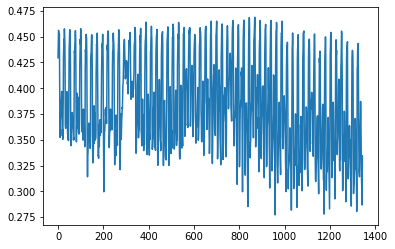

In [48]:
plt.plot(final_result_for_1st_round[final_result_for_1st_round['MeasName']==8]['pressure'].values)


In [49]:
final_result_for_1st_round[['id','pressure']].to_csv('submit_2021_02_XX.csv',index=False)